In [2]:
from rfgap import RFGAP
from dataset import dataprep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

## Read in the data and normalize

In [3]:
# TODO: Test with NumPy and Pandas, ALL METHODS and perhaps combos of each type.

In [4]:
data   = pd.read_csv('../datasets/iris.csv', sep = ',')
x, y   = dataprep(data)
n, d   = x.shape
n_classes = len(y.unique())

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

## Train the RF Model

In [6]:
rf = RFGAP(y = y_train, prox_method = 'rfgap', matrix_type = 'sparse', oob_score = True,
           random_state = 42)

In [7]:
rf.fit(x_train, y_train)

## Generate the Proximity Matrix

In [8]:
prox = rf.get_proximities()

## Check Sum-to-One

In [9]:
np.sum(prox.toarray(), axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

## Measures of Trust

### RF-ICE (Trust Scores)

In [10]:
ice_scores = rf.get_instance_classification_expectation()
print(rf.trust_auc)

0.9761036935647303


#### Accuracy Rejection Curve

Text(0.5, 1.0, 'Scatter Plot of Training Data with 1 - Trust Scores')

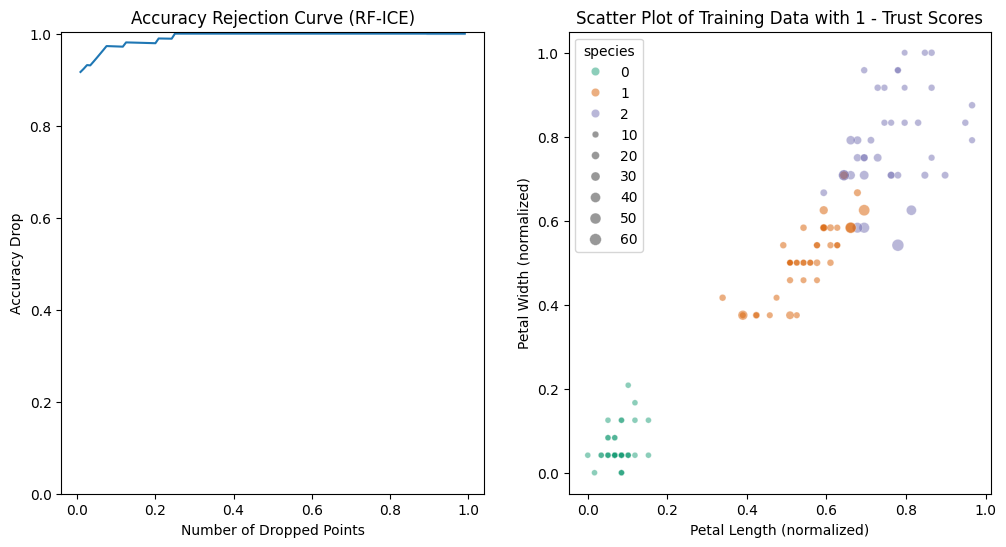

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(x=rf.trust_n_drop, y=rf.trust_accuracy_drop, ax=ax[0])
ax[0].set_xlabel('Number of Dropped Points')
ax[0].set_ylabel('Accuracy Drop')
ax[0].set_title('Accuracy Rejection Curve (RF-ICE)')
ax[0].set_ylim(0, None)

sns.scatterplot(x=x_train[:, 2], y=x_train[:, 3], hue=y_train, palette='Dark2',
                size=(np.max(rf.trust_scores) - rf.trust_scores) * 100 + 5, alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Petal Length (normalized)')
ax[1].set_ylabel('Petal Width (normalized)')
ax[1].set_title('Scatter Plot of Training Data with 1 - Trust Scores')


In [13]:
# RF-ICE for Test Set

In [42]:
trust_scores_test = rf.get_test_trust(x_test)

Text(0.5, 1.0, 'Scatter Plot of Training Data with 1 - Trust Scores')

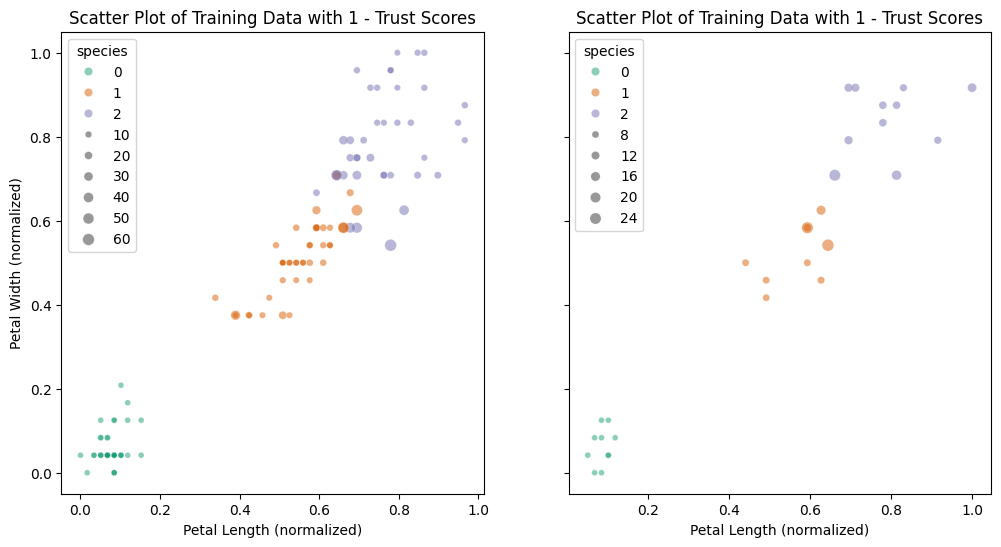

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

sns.scatterplot(x=x_train[:, 2], y=x_train[:, 3], hue=y_train, palette='Dark2',
                size=(np.max(rf.trust_scores) - rf.trust_scores) * 100 + 5, alpha=0.5, ax=ax[0])
ax[0].set_xlabel('Petal Length (normalized)')
ax[0].set_ylabel('Petal Width (normalized)')
ax[0].set_title('Training Data with 1 - Trust Scores')

sns.scatterplot(x=x_test[:, 2], y=x_test[:, 3], hue=y_test, palette='Dark2',
                size=(np.max(rf.trust_scores_test) - rf.trust_scores_test) * 100 + 5, alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Petal Length (normalized)')
ax[1].set_ylabel('Petal Width (normalized)')
ax[1].set_title('Test Data with 1 - Trust Scores')

In [14]:
rf.get_nonconformity(k = 5, x_test = x_test, proximity_type = 'rfgap')

In [48]:
rf.test_proximities.shape

(30, 120)

Text(0.5, 1.0, 'Scatter Plot of Training Data with Nonconformity Scores')

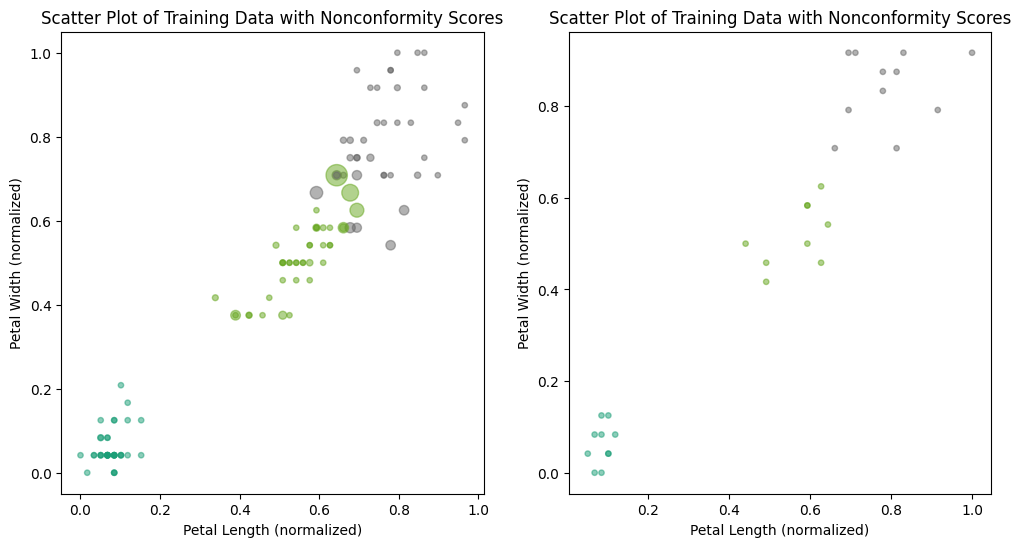

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


ax[0].scatter(x_train[:, 2], x_train[:, 3], c=y_train, cmap='Dark2', 
            s=rf.nonconformity_scores * 20 + 15, alpha=0.5)
ax[0].set_xlabel('Petal Length (normalized)')
ax[0].set_ylabel('Petal Width (normalized)')
ax[0].set_title('Scatter Plot of Training Data with Nonconformity Scores')


ax[1].scatter(x_test[:, 2], x_test[:, 3], c = y_test, cmap='Dark2', 
            s=rf.nonconformity_scores_test * 20 + 15, alpha=0.5)
ax[1].set_xlabel('Petal Length (normalized)')
ax[1].set_ylabel('Petal Width (normalized)')
ax[1].set_title('Scatter Plot of Training Data with Nonconformity Scores')

Text(0.5, 1.0, 'Conformity Accuracy Rejection Curve')

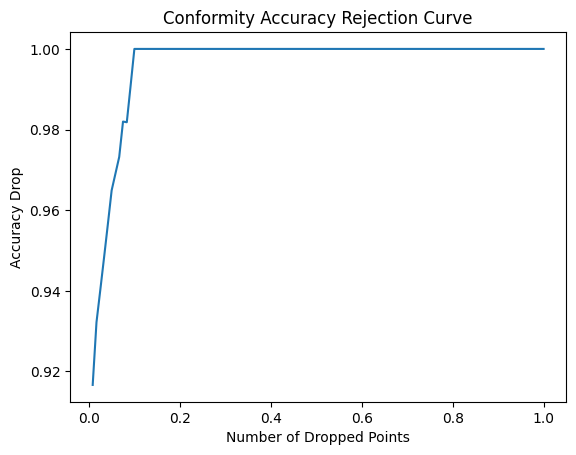

In [17]:
sns.lineplot(x=rf.conformity_n_drop, y=rf.conformity_accuracy_drop)
plt.xlabel('Number of Dropped Points')
plt.ylabel('Accuracy Drop')
plt.title('Conformity Accuracy Rejection Curve')

In [18]:
self.conformity_auc, self.conformity_accuracy_drop, self.conformity_n_drop = self.accuracy_rejection_auc(
                    self.conformity_quantiles, self.conformity_scores
                )

NameError: name 'self' is not defined

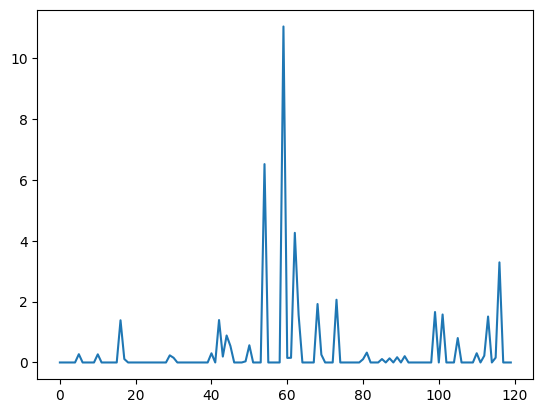

In [ ]:
plt.plot(rf.nonconformity_scores)

In [ ]:
                # Updates the following attributes:
                # - `self.nonconformity_scores`
                # - `self.conformity_scores`
                # - `self.conformity_quantiles`
                # - `self.conformity_auc`
                # - `self.conformity_accuracy_drop`
                # - `self.conformity_n_drop`
                
                # If `x_test` is provided, also updates:
                # - `self.nonconformity_scores_test`
                # - `self.conformity_scores_test`
                # - `self.conformity_quantiles_test`